# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак
- Price — цена (евро)

## Подготовка данных

### Импорт библитоек, модулей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import math

from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import  make_pipeline
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,roc_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

### Загрузка данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
display(df.info())
display(df.head(10))
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


В данных 354369  строк, и 16 столбцов. Присутствуют пропуски, присутствуют артефактные значения(Мощность больше 1500 л.с., год регистрации 1000 и 9999) В целевом признаке нет пропусков, но есть нулевые значения. Признаки  DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen, RegistrationMonth не нужны для обучения моделей. 

### Предобработка данных

In [4]:
display(df.duplicated().sum())# поиск и удаление дубликатов
df = df.drop_duplicates() 

4

In [5]:
df = df[df['Price']!=0].reset_index(drop=True)# удалим бесплатные автомобили

In [6]:
def find_mustache(column): # зададим функцию по поиску усов, все что вне усов является выбросами 
    describe = df[column].describe()
    box = describe[6] - describe[4]
    low_mustache = describe[4] - 1.5 * box
    up_mustache = describe[6] + 1.5 * box
    if low_mustache < describe[3]: 
        low_mustache = describe[3]
    if up_mustache > describe[7]:
        up_mustache = describe[7]
    return [low_mustache, up_mustache]

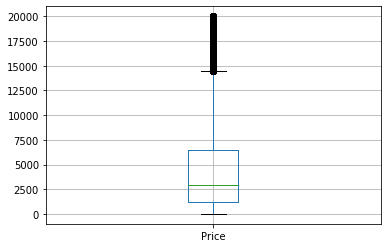

Price Усы [1.0, 14450.0]


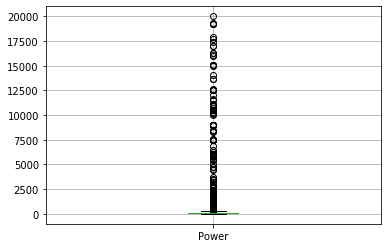

Power Усы [0.0, 254.0]


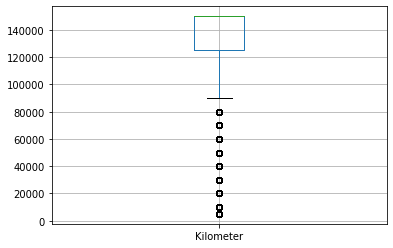

Kilometer Усы [87500.0, 150000.0]


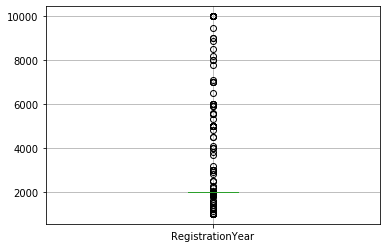

RegistrationYear Усы [1985.5, 2021.5]


In [7]:
for column in ['Price', 'Power', 'Kilometer', 'RegistrationYear']: # проверим на выбросы цену, мощность, год регистрации
    df.boxplot(column)
    plt.show()
    print(column, 'Усы', find_mustache(column))

In [8]:
df1 = df.query('Price <= 14450 and Power <= 254 and RegistrationYear > 1985 and RegistrationYear < 2021')
print('Потеря процентов от исходных данных: {:.2%}'.format(1 - (df1.shape[0] / df.shape[0])))


Потеря процентов от исходных данных: 8.41%


In [9]:
drop_col = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth']
df1 = df1.drop(drop_col, axis=1).reset_index(drop=True)
df1

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
314709,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
314710,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
314711,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
314712,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


#### Замена пропусков на моду 

In [10]:
df1["VehicleType"] = df1["VehicleType"].fillna(df1["VehicleType"].mode().values[0])
df1["Gearbox"] = df1["Gearbox"].fillna(df1["Gearbox"].mode().values[0])
df1["Model"] = df1["Model"].fillna(df1["Model"].mode().values[0])
df1["FuelType"] = df1["FuelType"].fillna(df1["FuelType"].mode().values[0])

df1["NotRepaired"] = df1["NotRepaired"].fillna("no")

In [11]:
df1.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.463477,0.442676,-0.305947
RegistrationYear,0.463477,1.000000,0.048616,-0.257176
Power,0.442676,0.048616,1.000000,0.115433
Kilometer,-0.305947,-0.257176,0.115433,1.000000


### Вывод по главе 

При обработке данных мы:
- избавились от дубликатов
- удалили выбросы, потеряли менее 9% данных(считаю не критическим)
- заменили пропуски на моду 
- удалили ненужные для обучения столбцы
- корреляция после обработки показала адекватные(логичные) значения


## Обучение моделей

#### Кодировка данных и разделение на выборки

In [12]:
df_ohe = pd.get_dummies(df1, drop_first=True)
df_light = df1.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "NotRepaired":'category'})

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(df_ohe.drop("Price",axis = 1),
                                             df_ohe["Price"],
                                             test_size = 0.25,
                                             random_state = 12345)


features_train, features_valid, target_train, target_valid = train_test_split(df1.drop("Price",axis = 1),
                                             df1["Price"],
                                             test_size = 0.25,
                                             random_state = 12345)

features_train_light, features_valid_light, target_train_light, target_valid_light = train_test_split(df_light.drop("Price",axis = 1),
                                             df_light["Price"],
                                             test_size = 0.25,
                                             random_state = 42)

#### Catboost


In [13]:
%%time
final_cat = CatBoostRegressor(depth=10, 
                              learning_rate=0.1,
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train, target_train,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","NotRepaired"]))

0:	learn: 3177.6277107	total: 857ms	remaining: 14m 16s
100:	learn: 1336.3904439	total: 1m 9s	remaining: 10m 23s
200:	learn: 1271.7834917	total: 2m 22s	remaining: 9m 27s
300:	learn: 1238.1972063	total: 3m 36s	remaining: 8m 21s
400:	learn: 1214.7307514	total: 4m 49s	remaining: 7m 12s
500:	learn: 1195.9261670	total: 6m 6s	remaining: 6m 4s
600:	learn: 1179.8629983	total: 7m 21s	remaining: 4m 52s
700:	learn: 1165.7767394	total: 8m 35s	remaining: 3m 39s
800:	learn: 1154.8284058	total: 9m 50s	remaining: 2m 26s
900:	learn: 1143.5458055	total: 11m 3s	remaining: 1m 12s
999:	learn: 1133.2947106	total: 12m 17s	remaining: 0us
CPU times: user 11min 16s, sys: 1min 3s, total: 12min 20s
Wall time: 12min 22s


In [14]:
%%time

print("CatBoost:", mean_squared_error(target_valid, final_cat.predict(features_valid))**0.5)

CatBoost: 1259.9219587098337
CPU times: user 1.7 s, sys: 71.1 ms, total: 1.77 s
Wall time: 1.75 s


#### LightGBM

In [15]:
%%time

lgb_train = lgb.Dataset(features_train_light, target_train_light)
lgb_valid = lgb.Dataset(features_valid_light, target_valid_light, reference=lgb_train)
parameters_light = {'metric': 'rmse', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_valid],
                verbose_eval=100)

[100]	training's rmse: 1307.58	valid_1's rmse: 1324.17
[200]	training's rmse: 1267.25	valid_1's rmse: 1298.79
[300]	training's rmse: 1242.8	valid_1's rmse: 1285.17
[400]	training's rmse: 1222.42	valid_1's rmse: 1274.82
[500]	training's rmse: 1206.05	valid_1's rmse: 1268.14
[600]	training's rmse: 1194.31	valid_1's rmse: 1264.65
[700]	training's rmse: 1183.27	valid_1's rmse: 1261.1
[800]	training's rmse: 1173.72	valid_1's rmse: 1258.31
[900]	training's rmse: 1164.14	valid_1's rmse: 1255.3
[1000]	training's rmse: 1156.92	valid_1's rmse: 1253.44
CPU times: user 52.3 s, sys: 0 ns, total: 52.3 s
Wall time: 53.4 s


In [16]:
%%time

print("LightGBM:", mean_squared_error(target_valid_light, light.predict(features_valid_light))**0.5)

LightGBM: 1253.4427132350927
CPU times: user 7.49 s, sys: 0 ns, total: 7.49 s
Wall time: 7.52 s


#### RandomForest

In [17]:
%%time

RF = RandomForestRegressor(criterion = "mse",random_state=12345,n_estimators = 100, max_depth=10)
RF.fit(features_train_ohe, target_train_ohe)

CPU times: user 4min 52s, sys: 0 ns, total: 4min 52s
Wall time: 4min 54s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [18]:
%%time

print("RandomForest:", mean_squared_error(target_valid_ohe, RF.predict(features_valid_ohe))**0.5)

RandomForest: 1537.5287793312793
CPU times: user 893 ms, sys: 0 ns, total: 893 ms
Wall time: 904 ms


####  LinearRegression


In [19]:
%%time

LR = LinearRegression()
LR.fit(features_train_ohe, target_train_ohe)

CPU times: user 18.3 s, sys: 5.78 s, total: 24.1 s
Wall time: 24.3 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
%%time

print("LinearRegression:", mean_squared_error(target_valid_ohe, LR.predict(features_valid_ohe))**0.5)

LinearRegression: 2107.098071046707
CPU times: user 149 ms, sys: 125 ms, total: 274 ms
Wall time: 287 ms


## Анализ моделей

In [21]:
df_time = pd.DataFrame({'Catboost':[1259.9219, 857, 2.05], 
                        'LightGBM':[1253.4427, 95, 8.63], 
                        'RandomForest':[1537.5287, 319, 0.98],
                        'LinearRegression':[2107.09807, 24.3, 0.173]}, 
                        index=['RMSE','fit time (sec)','predict time (sec)'])
df_time = df_time.T
df_time

,RMSE,fit time (sec),predict time (sec)
Catboost,1259.92190,857.0,2.050
LightGBM,1253.44270,95.0,8.630
RandomForest,1537.52870,319.0,0.980
LinearRegression,2107.09807,24.3,0.173


Из-за очень высокой RMSE на моделях RandomForest и   LinearRegression, не берем в сравнения эти модели, остается  Catboost и LightGBM. LightGBM выигрывает в 2 из 3 показателях, заказчику будем рекомендовать эту модель